In [177]:
import numpy as np
import os
import cv2
import tensorflow as tf
import tensorflow.keras as K
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt

%matplotlib inline

In [178]:
DATA_PATH = 'pokemon'
imageSize = 28

# getting training data
X_train = []

numImages = 0
for image in os.listdir(DATA_PATH):
    numImages += 1
    readImage = cv2.imread(os.path.join(DATA_PATH, image))
    readImage = cv2.resize(readImage, (imageSize, imageSize))
    X_train.append(readImage)

X_train = np.array(X_train).astype('float32')

In [179]:
# 819 images of size (200, 200) with 3 channels
print(X_train.shape)

BUFFER = X_train.shape[0]
BATCH_SIZE = 128

trainingData = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER).batch(BATCH_SIZE)

# just to check dimension
lst = list(trainingData.as_numpy_iterator())
print(len(lst))
print(len(lst[0]))
print(len(lst[-1]))
print(len(lst[0][0]))
print(len(lst[0][0][0]))
print(len(lst[0][0][0][0]))

(819, 28, 28, 3)
7
128
51
28
28
3


# Models

- Discriminator model
- Generator model

In [180]:
K.backend.clear_session()

def getDiscriminatorModel():
    model = K.models.Sequential([
        layers.Conv2D(32, (3, 3), padding = 'same', input_shape = (imageSize, imageSize, 3)),
        layers.LeakyReLU(),
        
        layers.Conv2D(64, (3, 3), strides = (2, 2), padding = 'same'),
        layers.LeakyReLU(),
        
        layers.Conv2D(128, (3, 3), strides = (2, 2), padding = 'same'),
        layers.LeakyReLU(),
        
        layers.Flatten(),
        layers.Dense(1),
    ], name = "discriminator sequential model")
    
    return model

In [181]:
discriminator = getDiscriminatorModel()

In [182]:
discriminator.summary()

Model: "discriminator sequential model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 

In [183]:
# from the summary above, we see that we get a 7x7x128 just before flattenning
nodes = 7*7*128

def getGeneratorModel():
    model = K.models.Sequential([
        layers.Dense(nodes, input_shape = (100,)),
        # shouldn't explode
        layers.BatchNormalization(),
        layers.Reshape((7, 7, 128)),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(128, (3, 3), padding = 'same'),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        # at this point the image is upsampled twice so we have 7*2*2 shaped image
        layers.Conv2DTranspose(1, (3, 3), padding = 'same')
    ], name = 'generator sequential model')
    
    return model

In [184]:
generator = getGeneratorModel()

In [185]:
generator.summary()

Model: "generator sequential model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         147584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 

(2, 28, 28, 1)


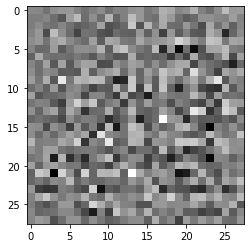

In [186]:
# testing the generator with some noise
noise = tf.random.normal([2, 100])
genImgs = generator(noise, training = False)
print(genImg.shape)
plt.imshow(genImg[0, :, :, 0], cmap = 'gray')

# Optimizers

In [187]:
genOpt = K.optimizers.Adam(lr = 1e-4)
discOpt = K.optimizers.Adam(lr = 1e-4)

# Losses

In [188]:
def getGeneratorLoss(fakePreds):
    return K.losses.BinaryCrossentropy(tf.ones_like(fakePreds), fakePreds)

In [189]:
def getDiscriminatorLoss(realPreds, fakePreds):
    rLoss = K.losses.BinaryCrossentropy(tf.ones_like(realPreds), realPreds)
    fLoss = K.losses.BinaryCrossentropy(tf.zeros_like(fakePreds), fakePreds)
    totalLoss = rLoss + fLoss
    return totalLoss

# Training

In [190]:
EPOCHS = 50

In [191]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print("Running epoch : " + str(epoch + 1))
        
        for pokemon in dataset:
            trainStep(pokemon)

In [192]:
# this decorator is used to 
@tf.function
def trainStep(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    
    with tf.GradientTape() as gen, tf.gradientTape() as disc:
        genImages = generator(noise, training = True)
        
        realOP = discriminator(images, training = True)
        fakeOP = discriminator(genImages, training = True)
        
        genLoss = getGeneratorLoss(fakeOP)
        discLoss = getDiscriminatorLoss(realOP, fakeOP)
        
    genGrads = gen.gradient(genLoss, generator.trainable_variables)
    discGrads = disc.gradient(discLoss, discriminator.trainable_variables)
    
    genOpt.apply_gradients(zip(genGrads, generator.trainable_variables))
    discOpt.apply_gradients(zip(discGrads, discriminator.trainable_variables))